In [1]:
%load_ext lab_black

# Vulnerability

Where do people and energy assets live?

In [2]:
import cartopy.crs as ccrs
from cartopy.feature import STATES, COASTLINE
import matplotlib.pyplot as plt
import pandas as pd
import regionmask
import seaborn as sns
import xarray as xr

from codebase.fig import figname

In [3]:
generators = pd.read_excel(
    "../data/raw/eia/gnovember_generator2020.xlsx",
    skiprows=2,
    sheet_name="Operating",
    index_col="Entity ID",
)

In [4]:
tx_generators = (
    generators.rename(
        columns={
            "Net Winter Capacity (MW)": "capacity_MW",
            "Technology": "tech",
            "Energy Source Code": "source",
            "Latitude": "lat",
            "Longitude": "lon",
        }
    )
    .loc[
        lambda df: df["Plant State"] == "TX",
        ["capacity_MW", "tech", "source", "lat", "lon"],
    ]
    .loc[lambda df: df["capacity_MW"] > 10]
    .assign(capacity_MW=lambda df: pd.to_numeric(df["capacity_MW"]))
    .dropna()
)

Now add in the population data

In [5]:
Xi, Xf = (-106, -92)
Yi, Yf = (27, 37)

In [6]:
pop = (
    xr.open_dataarray("../data/raw/gpwv4/gpw_v4_population_density_rev11_2pt5_min.nc")
    .sel(raster=5, longitude=slice(Xi, Xf), latitude=slice(Yf, Yi))
    .rename({"longitude": "lon", "latitude": "lat"})
)

Keep only population data from TX

In [7]:
states = regionmask.defined_regions.natural_earth.us_states_50
mask = states.mask(pop)
tx_idx = states.map_keys("Texas")
pop_tx = pop.where(mask == tx_idx)

Create data projections

In [8]:
map_proj = ccrs.PlateCarree()
data_proj = ccrs.PlateCarree()

Create the map

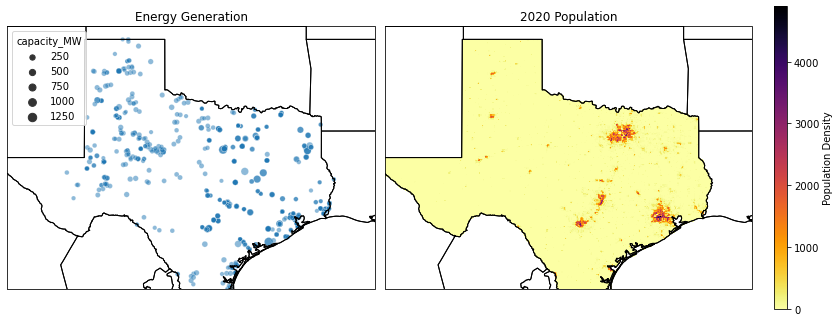

In [9]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, subplot_kw=dict(projection=map_proj), figsize=(12, 6)
)
ax = axes[0]
sns.scatterplot(
    x="lon",
    y="lat",
    size="capacity_MW",
    data=tx_generators,
    transform=data_proj,
    ax=ax,
    alpha=0.5,
)
ax.set_title("Energy Generation")

ax = axes[1]
C0 = pop_tx.plot(ax=ax, transform=data_proj, add_colorbar=False, cmap="inferno_r")
ax.set_title("2020 Population")

for ax in axes.flat:
    ax.add_feature(STATES)
    ax.add_feature(COASTLINE)
    ax.set_extent([Xi, Xf, Yi, Yf], crs=ccrs.PlateCarree())

fig.canvas.draw()
fig.tight_layout()
fig.subplots_adjust(right=0.875)
cax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(C0, cax=cax, label="Population Density")
plt.savefig(figname("vulnerability.pdf"))
plt.show()